## Introduction
The purpose of this notebook is to benchmark the properties of randomly generated (normalized) surface expansions which will be used to generate data for the operator learning model.

In [1]:
import pincell_moment_utils.postprocessing as pp
from pincell_moment_utils.plotting import reconstruction_comparison
import numpy as np
np.random.seed(42)

mesh_tally = pp.SurfaceMeshTally('../data/source_statepoint.100.h5')
expansion = pp.random_surface_expansion(7, 5, mesh_tally.energy_filters)

First, verify that each surface's flux function is normalized

In [2]:
expansion.integrate_flux(0)

1.0

Now inspect the generated flux function

/home/mlouis9/shared/Educational Stuffs/Classes/Spring 2025/Stat ML/Project/data_generation/src/pincell_moment_utils/plotting.py:45: RuntimeWarning: divide by zero encountered in divide
  plot_vals =  np.abs(mesh_vals -expansion_vals)/mesh_vals


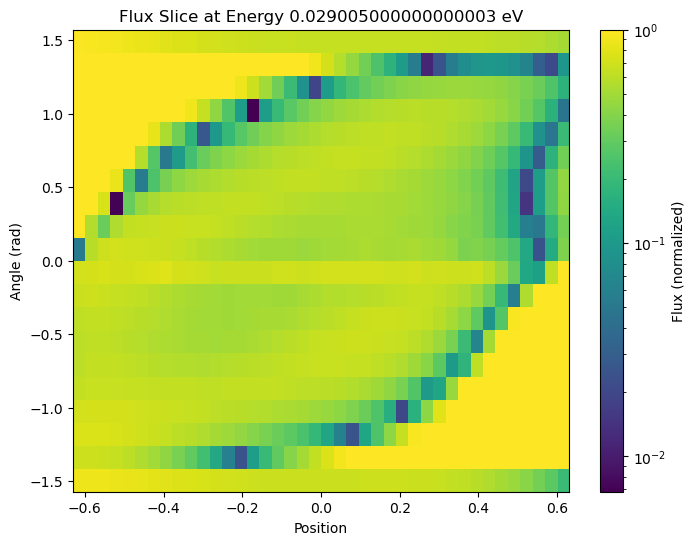

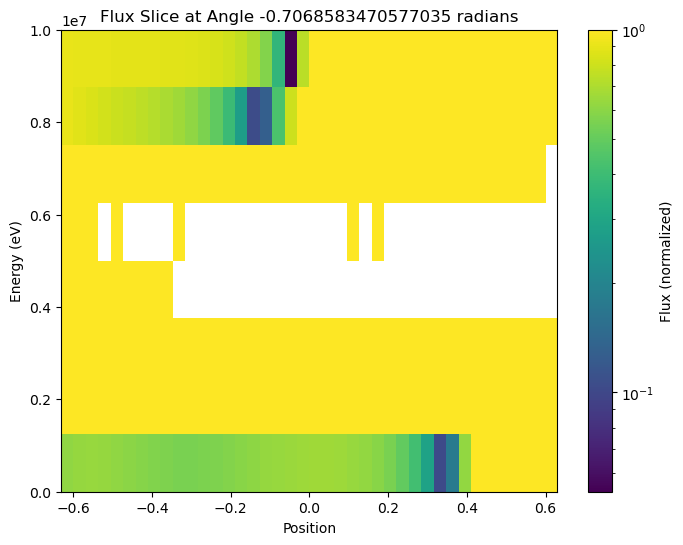

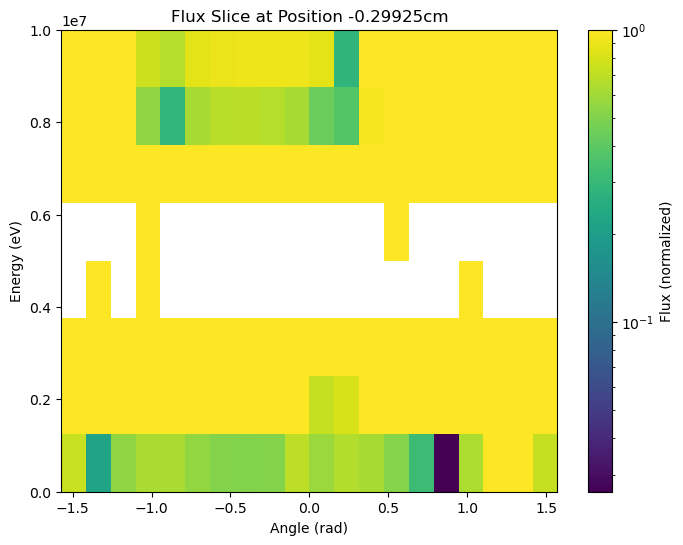

In [3]:
reconstruction_comparison(expansion, mesh_tally, 10, 5, 0, 0)

In [4]:
surface = 0
space_vals, angle_vals, energy_vals = mesh_tally.meshes[surface]
energy_filter = mesh_tally.energy_filters[surface]

expansion_vals = expansion.evaluate_on_grid(surface, (space_vals, angle_vals, energy_vals))

Now check various slices of the generated flux profile

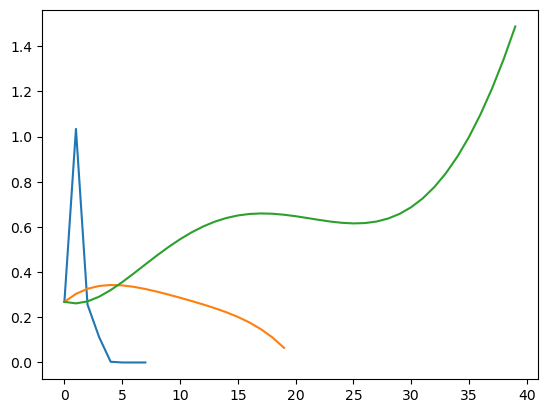

In [5]:
import matplotlib.pyplot as plt

plt.plot(expansion_vals[0, 0, :])
plt.plot(expansion_vals[0, :, 0])
plt.plot(expansion_vals[:, 0, 0])

All are seemingly reasonable, and apriori could be reasonable flux profiles

## Boundary Condition Parameterization
First, we note that the pincell has 90 degree rotational symmetry, and so we may parameterize the space of boundary conditions by considering first a set of $N_p$ randomly generated normalized single-surface incident flux functions. Then we uniformly generate a set of weights for the four surfaces $w_1, w_2, w_3, w_4$ such that each $w_i \in \text{linspace}[0,1, N_w]$. To respect the rotational symmetry of the domain (and to avoid generating unescessary samples), we consider only combinations of the $w_i$ that are unique up to cyclic permutations of the indices (corresponding to rotating the domain).

First, an example of the weight generation is shown below

In [29]:
from pincell_moment_utils.sampling import generate_unique_weight_combinations
import pandas as pd

n = 7  # Number of discrete values for each weight in [0,1]
weights, count = generate_unique_weight_combinations(n)

df = pd.DataFrame(weights, columns=["w1", "w2", "w3", "w4"])

In [30]:
df

,w1,w2,w3,w4
0,0.000000,0.000000,0.000000,1.000000
1,0.000000,0.000000,0.166667,0.833333
2,0.000000,0.000000,0.333333,0.666667
3,0.000000,0.000000,0.500000,0.500000
4,0.000000,0.166667,0.166667,0.666667
5,0.000000,0.166667,0.333333,0.500000
6,0.000000,0.333333,0.333333,0.333333
7,0.166667,0.166667,0.166667,0.500000
8,0.166667,0.166667,0.333333,0.333333


### The Total Number of Datapoints
Now, we note that, since we've explicitly chosen only weight sets that are unique up to cyclic permutations, we may then consider all permutations of incident flux profiles applied to nonzero weights (for the zero weight surfaces, there is clearly no dependence on the flux profile). So, we will have
$$
N_i = N_p\ P\ N_{\boldsymbol{w}_i \neq 0}= \frac{N_p!}{(N_p - N_{\boldsymbol{w}_i \neq 0})!},\hspace{5mm}i=1, \cdots, N_{wc}
$$
where $N_{wc}$ corresponds to the number of weight combinations, $N_p$ to the number of unique profiles generated, and $N_i$ to the number of combinations for each weight set $\boldsymbol{w}_i$. Then, the total number of training points will be
$$
N = \sum_{i=1}^{N_{wc}}N_i
$$
We consider the total number of datapoints $N$ as a function of both the number of weight values $N_w$ (_not_ the number of weight combinations), and the number of unique profiles $N_p$.

In [8]:
import numpy as np
import math

def compute_N(N_w, N_p):
    weights, N_wc = generate_unique_weight_combinations(N_w)
    num_nonzeros = [ np.count_nonzero(w) for w in weights ]
    return sum([ math.perm(N_p, num_nonzero) for num_nonzero in num_nonzeros ])

N_ws = np.arange(4, 10)
N_ps = np.arange(10, 1000)
N_vals = np.zeros((N_ws.size, N_ps.size))
for i, N_w, in enumerate(N_ws):
    for j, N_p, in enumerate(N_ps):
        N_vals[i, j] = compute_N(N_w, N_p)

(6, 990)


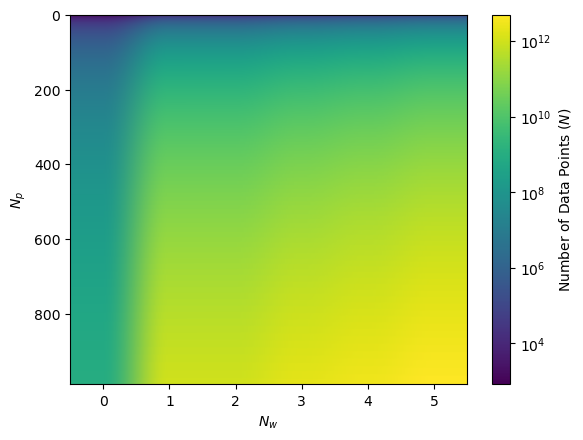

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

norm = mcolors.LogNorm(vmin=N_vals[N_vals > 0].min(), vmax=N_vals.max())  # Avoid log(0) issues

plt.imshow(N_vals.T, cmap='viridis', aspect='auto', norm=norm)
plt.xlabel('$N_w$')
plt.ylabel('$N_p$')
plt.colorbar(label='Number of Data Points ($N$)') 

The dimensionality of the proposed expansion functionalization is $d = 7\times 5 \times 8 \times 4 = 1120$ (the last factor of 4 comes from the fact that the model will take coefficients for all 4 surfaces as input). We'll shoot for around $N=10^7$, which should provide many more than the conservative heuristic of $10\times N_{\text{DNN params}}$. For simplicity, and since the profile is what matters most, we'll only choose 4-7 values, and leave the rest for profile samples

In [35]:
compute_N(7, 80)

77413760

which gives around the desired number of samples.